## Introduction

This notebook will be where I find the best parameters on the models that performed best for Model 2 (without T1, T2). I will do the final testing here as well.

In [1]:
# Load the necessary modules
# Relative paths (make sure you are in src)
import os, sys
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# Data management libraries 
import numpy as np 
import pandas as pd 

# My code
from data_processing import get_path
from Models.RandomForest import Random_Forest_ensemble
from Models.BaggingEnsemble import Bagging_Ensemble
from Models.Boosting import Boosting_Regressor
from utils import evaluate_regression_metrics
from data_processing import standarize_numerical_variables

# Machine learning libraries 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor,StackingRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Parameters
import configparser
config = configparser.ConfigParser()
config.read('../configuration.ini')

['../configuration.ini']

In [2]:
# Import data from relative path for train
file = get_path('created_files','train',parent_dir)
data = pd.read_csv(file,sep = ',')
X_train_p = data.drop(columns=['T3','T2','T1']).reset_index(drop=True)
y_train_p = data['T3'].reset_index(drop=True)

# Do the train/ test split and standarize AFTER so there is no data leakage
X_train, X_test, y_train_unstd, y_test_unstd = train_test_split(X_train_p,y_train_p,test_size=0.2)
X_train, X_test, y_train,y_test,scaler_y = standarize_numerical_variables(X_train, X_test, y_train_unstd, y_test_unstd,2)

# Import data from relative path for test
file_test = get_path('created_files','test',parent_dir)
data_test = pd.read_csv(file_test,sep = ',')
X_test_final = data.drop(columns=['T3','T2','T1']).reset_index(drop=True)
y_test_final = data['T3'].reset_index(drop=True)

## Ensemble Methods

In *Model2_Testing* I was able to see that the best performing models where Bagging, Random Forest and Boosting (Gradient), but all of them had scores that depended greatly on the parameters chosen so I will perform cross- validation on all of them. The best model will be chosen in *Metrics_Evaluator*.

#### 1. Bagging

Optimal value of n manual: 200 with a score of 0.34293289384721626
Optimal value of n sklearn: 300 with a score of 0.33000507523808287


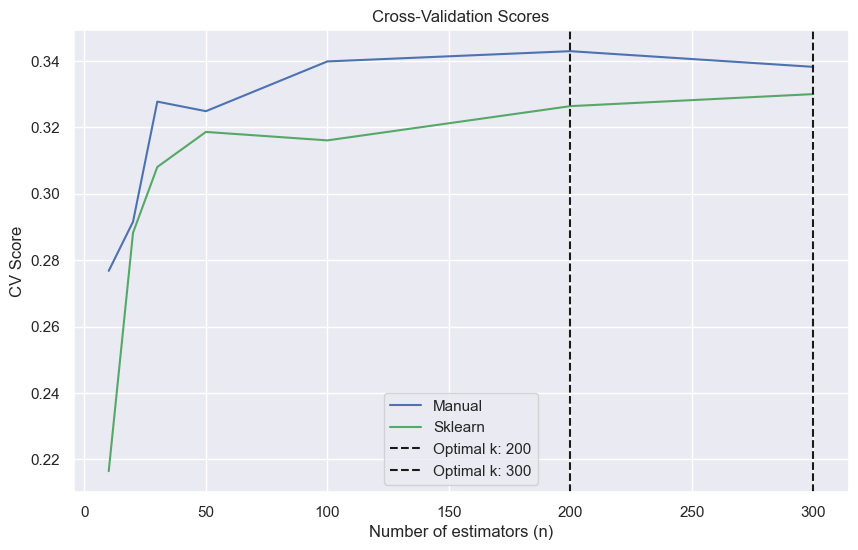

In [11]:
n_est = [10,20,30,50,100,200,300]
manual = []
sklearnn = []
max_samples = 0.8

for n_estimators in n_est:
    m = []
    s = []
    for _ in range(5): # To try and balance the variance
        bagging = Bagging_Ensemble(tipo = 'reg') 
        bagging.fit(X_train,X_test, y_train_unstd,n_estimators=n_estimators,max_samples=max_samples)
        bagging_pred = bagging.predict()
        score = bagging.score(y_test_unstd,y_train_unstd)
        m.append(score['R² Score Test:'])

        bagging = BaggingRegressor(random_state=0,n_estimators=n_estimators) 
        bagging.fit(X_train, y_train_unstd)
        bagging_pred = bagging.predict(X_test)
        bagging_pred_train = bagging.predict(X_train)
        score = evaluate_regression_metrics(y_test_unstd,y_train_unstd,bagging_pred,bagging_pred_train)
        s.append(score['R² Score Test:'])
    manual.append(np.mean(m))
    sklearnn.append(np.mean(s))

highest_score_manual = np.argmax(manual)
optimal_k_manual = n_est[highest_score_manual]

highest_score_sk = np.argmax(sklearnn)
optimal_k_sk = n_est[highest_score_sk]

print(f"Optimal value of n manual: {optimal_k_manual} with a score of {manual[highest_score_manual]}")
print(f"Optimal value of n sklearn: {optimal_k_sk} with a score of {sklearnn[highest_score_sk]}")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(n_est,manual,'b',label= 'Manual')
plt.plot(n_est,sklearnn,'g',label='Sklearn')
plt.axvline(x=optimal_k_manual, linestyle='--', color='k', label=f'Optimal k: {optimal_k_manual}')
plt.axvline(x=optimal_k_sk, linestyle='--', color='k', label=f'Optimal k: {optimal_k_sk}')

plt.title('Cross-Validation Scores')
plt.xlabel('Number of estimators (n)')
plt.ylabel('CV Score')
plt.legend()
plt.grid(True)
plt.show()

#### 2. Random Forest

Optimal value of n manual: 300 with a score of 0.3534991348895212
Optimal value of n sklearn: 200 with a score of 0.3536537924976072


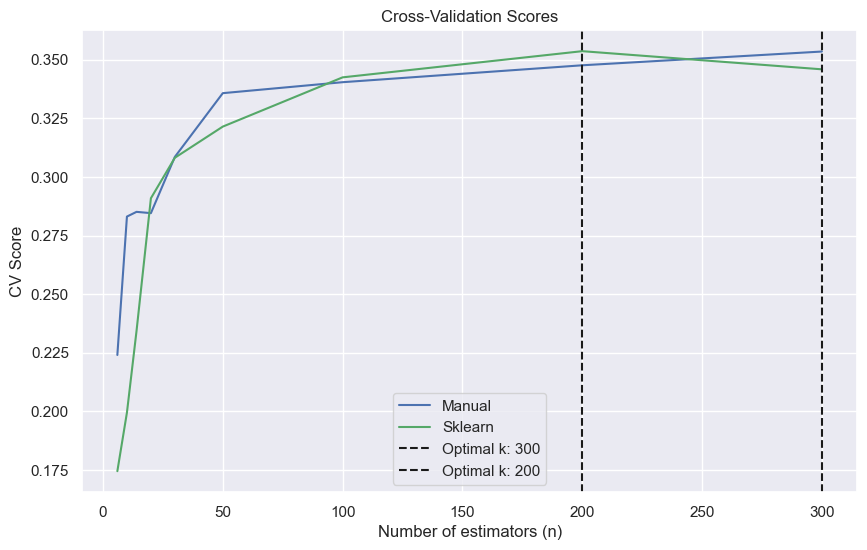

In [14]:
max_samples = 0.8
tipo = 'reg'
max_features = 0.8
manual = []
sklearnn = []
n_est = [6,10,14,20,30,50,100,200,300]

for n_estimators in n_est:
    m = []
    s = []
    for _ in range(5): # To try and balance the variance
        rf = Random_Forest_ensemble(tipo = 'reg') 
        rf.fit(X_train,X_test, y_train_unstd,n_estimators=n_estimators,max_samples=max_samples,max_features=max_features)
        rf_pred = rf.predict()
        score = rf.score(y_test_unstd,y_train_unstd)
        m.append(score['R² Score Test:'])

        rf = RandomForestRegressor(random_state=0,n_estimators=n_estimators,max_features=max_features) 
        rf.fit(X_train, y_train_unstd)
        rf_pred = rf.predict(X_test)
        rf_pred_train = rf.predict(X_train)
        score = evaluate_regression_metrics(y_test_unstd,y_train_unstd,rf_pred,rf_pred_train)
        s.append(score['R² Score Test:'])
    manual.append(np.mean(m))
    sklearnn.append(np.mean(s))

highest_score_manual = np.argmax(manual)
optimal_k_manual = n_est[highest_score_manual]

highest_score_sk = np.argmax(sklearnn)
optimal_k_sk = n_est[highest_score_sk]

print(f"Optimal value of n manual: {optimal_k_manual} with a score of {manual[highest_score_manual]}")
print(f"Optimal value of n sklearn: {optimal_k_sk} with a score of {sklearnn[highest_score_sk]}")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(n_est,manual,'b',label= 'Manual')
plt.plot(n_est,sklearnn,'g',label='Sklearn')
plt.axvline(x=optimal_k_manual, linestyle='--', color='k', label=f'Optimal k: {optimal_k_manual}')
plt.axvline(x=optimal_k_sk, linestyle='--', color='k', label=f'Optimal k: {optimal_k_sk}')

plt.title('Cross-Validation Scores')
plt.xlabel('Number of estimators (n)')
plt.ylabel('CV Score')
plt.legend()
plt.grid(True)
plt.show()

#### 3. Gradient Boosting

Optimal value of n manual: 100 with a score of 0.31456767596611435
Optimal value of n sklearn: 200 with a score of 0.3664361847358667


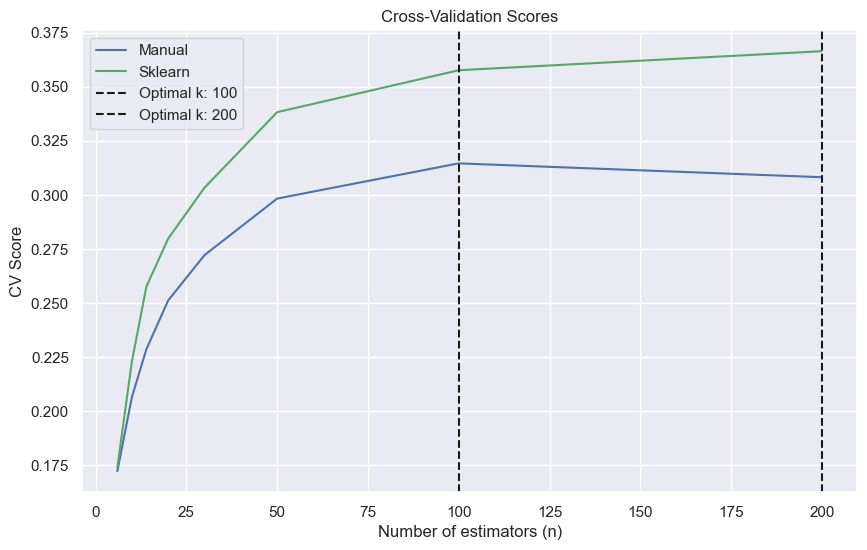

In [15]:
n_est = [6,10,14,20,30,50,100,200]
sklearnn = []
manual = []
max_samples = 0.8

for n_estimators in n_est:
    m = []
    s = []
    for _ in range(5): # To try and balance the variance
        gb = Boosting_Regressor(n_estimators=n_estimators)
        gb.fit(X_train, y_train_unstd)
        gb_pred = gb.predict(X_test)
        gb_pred_train = gb.predict(X_train)
        score = evaluate_regression_metrics(y_test_unstd, y_train_unstd, gb_pred, gb_pred_train)
        m.append(score['R² Score Test:'])

        gb = GradientBoostingRegressor(n_estimators=n_estimators,max_features=max_features,subsample=max_samples,random_state=0)
        gb.fit(X_train, y_train_unstd)
        gb_pred = gb.predict(X_test)
        gb_pred_train = gb.predict(X_train)
        score = evaluate_regression_metrics(y_test_unstd, y_train_unstd, gb_pred, gb_pred_train)
        s.append(score['R² Score Test:'])
    manual.append(np.mean(m))
    sklearnn.append(np.mean(s))

highest_score_manual = np.argmax(manual)
optimal_k_manual = n_est[highest_score_manual]

highest_score_sk = np.argmax(sklearnn)
optimal_k_sk = n_est[highest_score_sk]

print(f"Optimal value of n manual: {optimal_k_manual} with a score of {manual[highest_score_manual]}")
print(f"Optimal value of n sklearn: {optimal_k_sk} with a score of {sklearnn[highest_score_sk]}")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(n_est,manual,'b',label= 'Manual')
plt.plot(n_est,sklearnn,'g',label='Sklearn')
plt.axvline(x=optimal_k_manual, linestyle='--', color='k', label=f'Optimal k: {optimal_k_manual}')
plt.axvline(x=optimal_k_sk, linestyle='--', color='k', label=f'Optimal k: {optimal_k_sk}')

plt.title('Cross-Validation Scores')
plt.xlabel('Number of estimators (n)')
plt.ylabel('CV Score')
plt.legend()
plt.grid(True)
plt.show()
    

Optimal value of mf manual: 0.1 with a score of 0.2984087676047517
Optimal value of mf sklearn: 0.1 with a score of 0.34648788637286


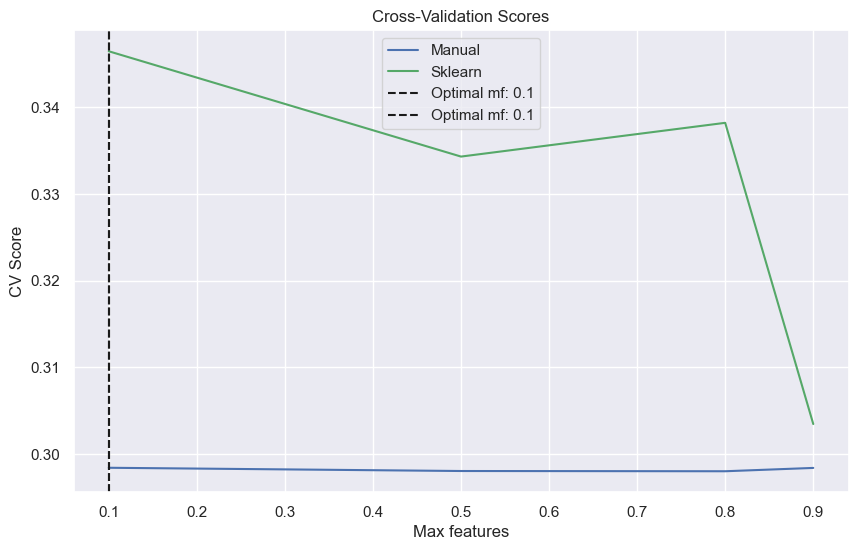

In [ ]:
n_estimators = 50
sklearnn = []
manual = []
max_samples = 0.8
max_featuress = [0.1,0.5,0.8,0.9]

for max_feature in max_featuress:
    m = []
    s = []
    for _ in range(5): # To try and balance the variance
        gb = Boosting_Regressor(n_estimators=n_estimators) # It doesn't have the parameter we are trying so it will not vary
        gb.fit(X_train, y_train_unstd)
        gb_pred = gb.predict(X_test)
        gb_pred_train = gb.predict(X_train)
        score = evaluate_regression_metrics(y_test_unstd, y_train_unstd, gb_pred, gb_pred_train)
        m.append(score['R² Score Test:'])

        gb = GradientBoostingRegressor(n_estimators=n_estimators,max_features=max_feature,subsample=max_samples,random_state=0)
        gb.fit(X_train, y_train_unstd)
        gb_pred = gb.predict(X_test)
        gb_pred_train = gb.predict(X_train)
        score = evaluate_regression_metrics(y_test_unstd, y_train_unstd, gb_pred, gb_pred_train)
        s.append(score['R² Score Test:'])
    manual.append(np.mean(m))
    sklearnn.append(np.mean(s))

highest_score_manual = np.argmax(manual)
optimal_k_manual = max_featuress[highest_score_manual]

highest_score_sk = np.argmax(sklearnn)
optimal_k_sk = max_featuress[highest_score_sk]

print(f"Optimal value of mf manual: {optimal_k_manual} with a score of {manual[highest_score_manual]}")
print(f"Optimal value of mf sklearn: {optimal_k_sk} with a score of {sklearnn[highest_score_sk]}")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(max_featuress,manual,'b',label= 'Manual')
plt.plot(max_featuress,sklearnn,'g',label='Sklearn')
plt.axvline(x=optimal_k_manual, linestyle='--', color='k', label=f'Optimal mf: {optimal_k_manual}')
plt.axvline(x=optimal_k_sk, linestyle='--', color='k', label=f'Optimal mf: {optimal_k_sk}')

plt.title('Cross-Validation Scores')
plt.xlabel('Max features')
plt.ylabel('CV Score')
plt.legend()
plt.grid(True)
plt.show()

Optimal value of n_samples sklearn: 0.5 with a score of 0.40588900695635904


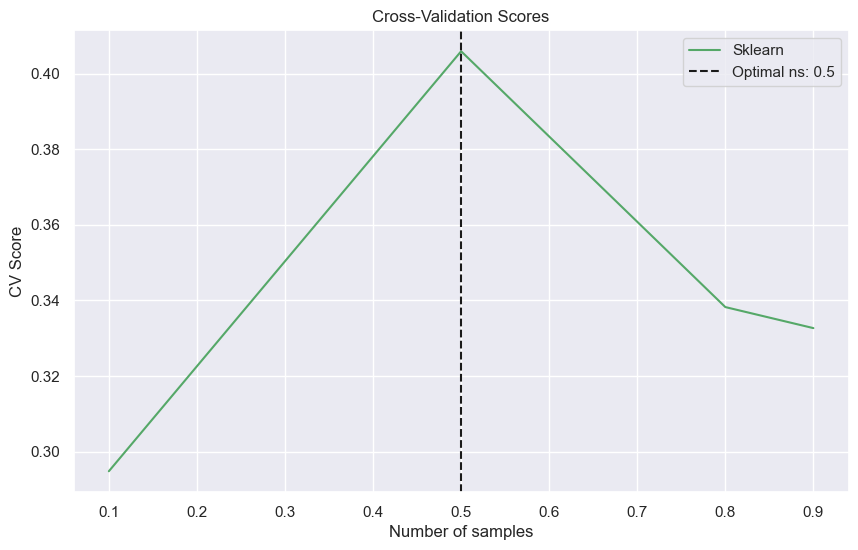

In [19]:
n_estimators = 50
sklearnn = []
max_samples = [0.1,0.5,0.8,0.9]
max_features = 0.8

# SInce my implementation doesn't have max_samples, I will do CV only on the sklearn model
for max_sample in max_samples:
    s = []
    for _ in range(5): # To try and balance the variance
        gb = GradientBoostingRegressor(
            n_estimators=n_estimators,
            max_features=max_features,
            subsample=max_sample,
            random_state=0
        )
        gb.fit(X_train, y_train_unstd)
        gb_pred = gb.predict(X_test)
        gb_pred_train = gb.predict(X_train)
        score = evaluate_regression_metrics(y_test_unstd, y_train_unstd, gb_pred, gb_pred_train)
        s.append(score['R² Score Test:'])
    sklearnn.append(np.mean(s))

highest_score_sk = np.argmax(sklearnn)
optimal_k_sk = max_samples[highest_score_sk]

print(f"Optimal value of n_samples sklearn: {optimal_k_sk} with a score of {sklearnn[highest_score_sk]}")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(max_samples,sklearnn,'g',label='Sklearn')
plt.axvline(x=optimal_k_sk, linestyle='--', color='k', label=f'Optimal ns: {optimal_k_sk}')

plt.title('Cross-Validation Scores')
plt.xlabel('Number of samples')
plt.ylabel('CV Score')
plt.legend()
plt.grid(True)
plt.show()

### Stacks

It makes sense the stack that combines the best models individually performs better.


In [23]:
base_models = [
    ('lasso', LassoCV(cv=5)),
    ('RF', RandomForestRegressor(random_state=42)),
]
base_models1 = [
    ('RF', RandomForestRegressor(random_state=42)),
    ('svm', SVR(C=1.0, epsilon=0.2))
]

base_models2 = [
    ('gbr', GradientBoostingRegressor(random_state=42)),
    ('svr', SVR(C=1.0, epsilon=0.2)),
    ('ridge', RidgeCV(alphas=[0.1, 1.0, 10.0]))
]
base_models_3 = [
    ('gbr', GradientBoostingRegressor(n_estimators=100,max_features=0.8,subsample=0.5,random_state=42)),
    ('RF', RandomForestRegressor(random_state=42,n_estimators=200,max_features=0.8) ),
    ('bag', BaggingRegressor(random_state=42,n_estimators=200)),
    ('svr', SVR(C=10, gamma='scale',kernel='rbf'))
]
base_models_4 = [
    ('lr', LinearRegression()),
    ('lasso', LassoCV(cv=5)),
    ('RF', RandomForestRegressor(random_state=42)),
    ('svm', SVR(C=1.0, epsilon=0.2)),
]
base_models_5 = [  # Best models out of cross validation
    ('gbr', GradientBoostingRegressor(n_estimators=100,max_features=0.8,subsample=0.5,random_state=42)),
    ('RF', RandomForestRegressor(random_state=42,n_estimators=200,max_features=0.8) ),
    ('bag', BaggingRegressor(random_state=42,n_estimators=200)),
]

pipe = Pipeline([
    ('stack', StackingRegressor(estimators=base_models, final_estimator=LinearRegression(),cv=5,passthrough=True,n_jobs=-1)),
])

param_grid = {
    'stack__final_estimator': [LassoCV(), GradientBoostingRegressor(n_estimators=100,max_features=0.8,subsample=0.5,random_state=42)],
    'stack__estimators': [base_models,base_models1,base_models2,base_models_3,base_models_4,base_models_5]
}
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train_unstd)

y_pred = grid_search.predict(X_test)
y_pred_t = grid_search.predict(X_train)


print("Best parameters found:", grid_search.best_params_)
print("Best score (CV):", grid_search.best_score_)

results = evaluate_regression_metrics(y_test_unstd, y_train_unstd, y_pred, y_pred_t)
print(results)

Best parameters found: {'stack__estimators': [('gbr', GradientBoostingRegressor(max_features=0.8, random_state=42, subsample=0.5)), ('RF', RandomForestRegressor(max_features=0.8, n_estimators=200, random_state=42)), ('bag', BaggingRegressor(n_estimators=200, random_state=42)), ('svr', SVR(C=10))], 'stack__final_estimator': LassoCV()}
Best score (CV): 0.2828028819985918
{'Mean Absolute Error:': 2.3233555832216606, 'Mean Squared Error:': 9.635509320764003, 'R² Score Test:': 0.41276989024202226, 'R² Score Train:': 0.7766362964104538}


### SVR and Linear Regression with Kernel-PCA

I already conducted cross validation on both in *Model2_Testing*, you can check it out there.